## Gradients

A gradient is a thing that points in the direction of biggest increase.

It's easiest with an example. We'll define a vector along with it's `angle` and `length`. We calculate the gradient of both `angle` and `length` and see that it points in the direction of greatest increase.

2024-11-28 10:01:50.981768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732816910.994527   68113 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732816910.998203   68113 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 10:01:51.010855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1732816912.128671   68113 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 63

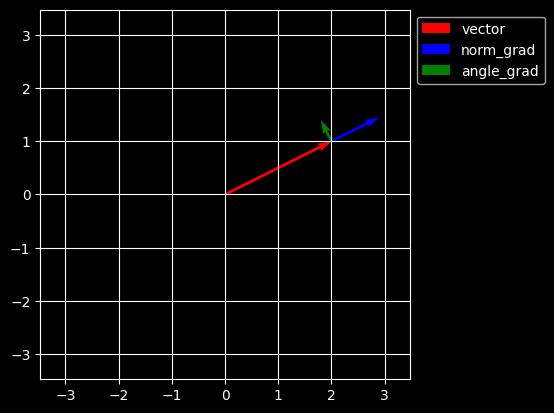

In [1]:
from dlib.helper import VectorScene
import tensorflow as tf

vector = tf.Variable([2.0,1.0])

with tf.GradientTape(persistent=True) as tape:
    length = tf.sqrt(tf.reduce_sum(vector*vector))
    angle = tf.atan2(vector[1], vector[0])
    
norm_grad = tape.gradient(length, vector)
angle_grad = tape.gradient(angle, vector)
del tape

scene = VectorScene()
(scene
 .add_vector(vector, color='r', label='vector')
 .add_vector_at(vector, norm_grad, color='b', name='norm_grad')
 .add_vector_at(vector, angle_grad, color='g', name='angle_grad')
 .display()
 )





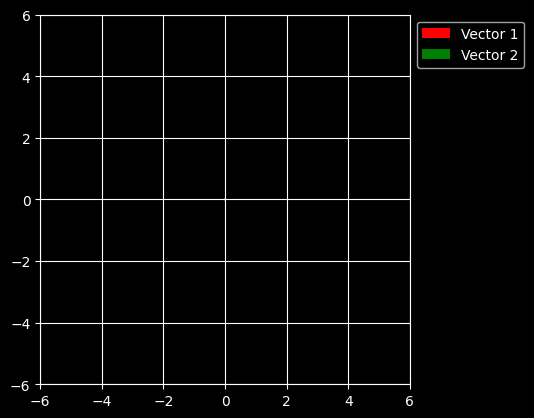

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class AnimatedVectorScene:
    def __init__(self):
        plt.style.use('dark_background')
        self.fig, self.ax = plt.subplots()
        self.animated_vectors = []  # Store animated vectors as (start_list, delta_list, color, name)
    
    def add_animated_vector(self, vector_list, color='b', label='vector'):
        if hasattr(vector_list, 'numpy'):
            vector_list = vector_list.numpy()
        self.add_animated_vector_at([[0, 0]] * len(vector_list), vector_list, color, label)
        return self

    def add_animated_vector_at(self, start_vector_list, delta_vector_list, color='b', name='vector'):
        if hasattr(start_vector_list, 'numpy'):
            start_vector_list = start_vector_list.numpy()
        if hasattr(delta_vector_list, 'numpy'):
            delta_vector_list = delta_vector_list.numpy()
        
        if len(start_vector_list) != len(delta_vector_list):
            raise ValueError("start_vector_list and delta_vector_list must have the same length.")
        
        self.animated_vectors.append((start_vector_list, delta_vector_list, color, name))
        return self

    def animate(self,name, interval=100):
        self.ax.set_aspect('equal')
        largest = 0

        # Determine plot limits dynamically
        for starts, deltas, _, _ in self.animated_vectors:
            for start, delta in zip(starts, deltas):
                end_x = start[0] + delta[0]
                end_y = start[1] + delta[1]
                largest = max(largest, abs(end_x), abs(end_y), abs(start[0]), abs(start[1]))

        self.ax.set_xlim([-1.2 * largest, 1.2 * largest])
        self.ax.set_ylim([-1.2 * largest, 1.2 * largest])
        plt.grid()

        quivers = []  # To store quiver objects for updating in animation

        # Initialize quivers
        for starts, _, color, label in self.animated_vectors:
            quiver = self.ax.quiver(
                starts[0][0], starts[0][1], 0, 0, angles='xy', scale_units='xy', scale=1, color=color, label=label
            )
            quivers.append(quiver)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Update function for animation
        def update(frame):
            for quiver, (starts, deltas, _, _) in zip(quivers, self.animated_vectors):
                start = starts[frame]
                delta = deltas[frame]
                quiver.set_offsets([start])  # Update start position
                quiver.set_UVC(delta[0], delta[1])  # Update vector direction and magnitude
            return quivers

        # Create animation
        frames = len(self.animated_vectors[0][0])  # Assume all vectors have the same number of frames
        plt.show()
        anim = FuncAnimation(self.fig, update, frames=frames, interval=interval, blit=True)
        anim.save(f'video/{name}.gif', writer='imagemagick', fps=5)


scene = AnimatedVectorScene()

# Example 1: Animated vector starting at the origin
scene.add_animated_vector(
    vector_list=[[1, 2], [2, 3], [3, 4], [4, 5]], 
    color='r', 
    label='Vector 1'
)

# Example 2: Animated vector with a moving starting point
scene.add_animated_vector_at(
    start_vector_list=[[0, 0], [1, 1], [2, 2], [3, 3]],
    delta_vector_list=[[1, 1], [1, 0], [0, -1], [-1, -1]],
    color='g',
    name='Vector 2'
)

scene.animate(name='mine', interval=500)


In [ ]:
## Gradients in Tensorflow

import tensorflow as tf
import numpy as np

# Define the target vector
target_vector = tf.constant([-np.sqrt(2), np.sqrt(2)], dtype=tf.float32)

# Initialize the variable vector to be optimized
vector = tf.Variable([0.001, 0.0], dtype=tf.float32)

# Define the learning rate
learning_rate = 0.1
vector_steps = []
# Optimization loop
for step in range(100):
    with tf.GradientTape() as tape:
        distance_from_unit = (1-tf.reduce_sum(vector * vector)) ** 2
        orthogonality = tf.reduce_sum(vector * target_vector)**2
        loss = distance_from_unit + orthogonality
    
    if loss < 1e-6:
        break
    # Compute the gradients of the loss with respect to the vector
    gradients = tape.gradient(loss, [vector])
    
    # Update the vector using the gradients
    vector.assign_sub(learning_rate * gradients[0])
    vector_steps.append(vector.numpy())



2024-11-28 06:58:37.005855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732805917.086832    5595 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732805917.109432    5595 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 06:58:37.268644: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1732805918.911085    5595 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 65

[array([0.001 , 0.0004], dtype=float32), array([0.00116, 0.0008 ], dtype=float32), array([0.00148 , 0.001264], dtype=float32), array([0.0019856, 0.001856 ], dtype=float32), array([0.00272799, 0.00265023], dtype=float32), array([0.00378806, 0.00374141], dtype=float32), array([0.00528458, 0.00525659], dtype=float32), array([0.0073871 , 0.00737031], dtype=float32), array([0.01033491, 0.01032483], dtype=float32), array([0.01446395, 0.01445791], dtype=float32), array([0.0202447 , 0.02024107], dtype=float32), array([0.02833449, 0.02833232], dtype=float32), array([0.03964922, 0.03964791], dtype=float32), array([0.05545852, 0.05545774], dtype=float32), array([0.07750516, 0.07750469], dtype=float32), array([0.10813458, 0.1081343 ], dtype=float32), array([0.15037677, 0.1503766 ], dtype=float32), array([0.20780702, 0.20780692], dtype=float32), array([0.28375068, 0.28375062], dtype=float32), array([0.3789741 , 0.37897408], dtype=float32), array([0.48702073, 0.4870207 ], dtype=float32), array([0.58

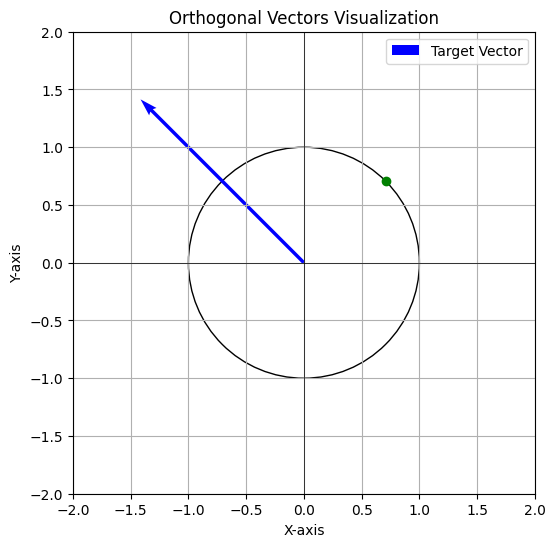

In [40]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
ax.axhline(0, color='black', linewidth=0.5)  # X-axis
ax.axvline(0, color='black', linewidth=0.5)  # Y-axis

# Plot a unit circle
circle = plt.Circle((0, 0), 1, color='black', fill=False)
ax.add_artist(circle)

# Set up the plot limits, labels, and grid
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)
ax.set_aspect('equal', adjustable='box')
ax.set_title('Orthogonal Vectors Visualization')

# Add legend
quiver_target = ax.quiver(0, 0, target_vector[0], target_vector[1],
                          angles='xy', scale_units='xy', scale=1, color='blue', label='Target Vector')

point_plot, = ax.plot([], [], 'go')  # For animating the steps
ax.legend()

# Initialization function for animation
def init():
    point_plot.set_data([], [])
    return point_plot,

# Update function for animation
def update(frame):
    # Update the point for the current step
    step = vector_steps[frame]
    point_plot.set_data([step[0]], [step[1]])  # Ensure x and y are sequences
    return point_plot,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(vector_steps), init_func=init, blit=True, interval=100)


ani.save(f'video/vector_animation.mp4', writer='ffmpeg', fps=10) 
plt.show()


# Training


In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train_arr, y_train_arr), (x_test_arr, y_test_arr) = mnist.load_data()
x_train, x_test, y_train, y_test = tf.convert_to_tensor(x_train_arr), tf.convert_to_tensor(x_test_arr), tf.convert_to_tensor(y_train_arr), tf.convert_to_tensor(y_test_arr)


In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')
])

/home/jackson/code/dl/venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:

def loss_fn(predictions, labels):
    log_probs = tf.math.log(predictions + 1e-36)
    one_hot = tf.one_hot(labels, 10)
    losses = -tf.reduce_sum(one_hot * log_probs, axis=1)
    return tf.reduce_mean(losses)

pred_train = model(x_train)
loss_fn(pred_train, y_train)



<tf.Tensor: shape=(), dtype=float32, numpy=72.3472671508789>

We would expect a naive model to have a mean log probability of $log(1/10)\approx 2.3$. But in this case, we are getting a higher number, this is because the unutilized model is very confidently wrong. Therefore we get many logs of near 0 values. 

## The Gradient

How do we improve this linear model?

In [6]:
with tf.GradientTape() as tape:
    pred_train = model(x_train)

    loss = loss_fn( pred_train, y_train)

gradients = tape.gradient(loss, model.trainable_variables)


Reshaped gradient shape: (28, 28, 10)


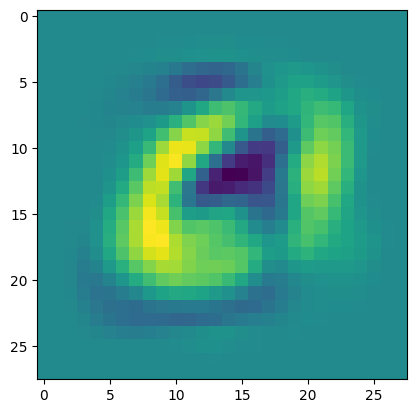

In [7]:
# let's look at gradients



from matplotlib import pyplot as plt

reshaped_gradient = tf.reshape(gradients[0], (28, 28, 10))
print("Reshaped gradient shape:", reshaped_gradient.shape)

plt.imshow(reshaped_gradient[:,:, 3])